# Time Domain: Exploring light SDSS light curves
In this notebook we explore several things studied in classs for the analysis of astronomical light curves. We first demonstrate how the light curve of a RR Lyrae star can be decomposed into a series of harmonic signals, using Fast Fourier Transform. We then show some examples of bootstrapping using the same Chandra date we used in Lecture 2. We then go back to the light curves and compute single-band and multi-band periodograms in order to find their periods, and apply bootstraping to find the significance of the periodic signal found. This notebook is heavily based on work by Jake Vanderplas.

## Fast Fourier Transform of an RR Lyrae Light Curve
Here we take a template for the light curve of an RR Lyrae and perform a Fast Fourier Transform (FFT) fit to it.

In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_rrlyrae_templates

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Load the RR Lyrae template
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8]
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y)
    y_fft[k + 1:-k] = 0
    y_fit = np.fft.ifft(y_fft).real

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)
plt.show()

## Bootstrapping
We have discussed in the lecture the concept of bootstrapping, which consists on estimating the parameters of a population by using a single sample of that population. Here we demonstrate it using the distribution of detected photons in the Chandra ACIS data that we have seen in previous lectures.

Text(0,0.5,'N')

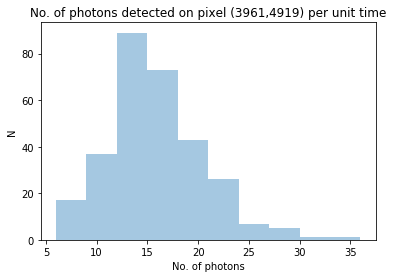

In [2]:
# Load the data first
from astropy.io import fits
hdul = fits.open('Data_Lecture4/acisf18344N001_evt2.fits')

# Create a mask to select the desired pixel
mask = ((hdul[1].data['ccd_id']==7) 
        & (hdul[1].data['dety']>=3961.)
        & (hdul[1].data['dety']<3962.)
        & (hdul[1].data['detx']>=4519.)
        & (hdul[1].data['detx']<4920.))

# Get the times of arrival of the photos for that pixel
times = np.array(hdul[1].data['time'][mask])

# Split the time into equal intervals
t_intvls = np.linspace(np.min(times),np.max(times),300)

# Count how many photos were detected in each equal time interval
n_events = []
for i in range(len(t_intvls[0:-1])):
    n_events.append(len(times[(times>t_intvls[i]) & (times<t_intvls[i+1])]))

#Plot the histogram
plt.hist(n_events,alpha=0.4)
plt.title('No. of photons detected on pixel (3961,4919) per unit time')
plt.xlabel('No. of photons')
plt.ylabel('N')

Now that we have a sample of events, we will use bootstrapping to try to estimate parameters of the entire population, and to estimate the error in the determination of those parameters due to sampling. We do it here for the mean of the distribution, both parametric and non-parametric.

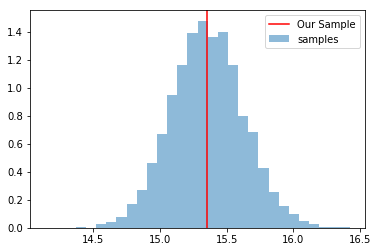

In [3]:
# Bootstrapping
n_events = np.array(n_events) # The total number of events in our sample
M_samples=10000  # The number of bootstrap samples we want
N_points = n_events.shape[0]  # The number of points we want to samples from the dist.

# Let's sample with replacement.
bs_np = np.random.choice(n_events, size=(M_samples, N_points), replace=True)

# Calculate the mean
sd_mean=np.mean(bs_np, axis=1)

# And the standard deviation
sd_std=np.std(bs_np, axis=1)

# Plot results
plt.hist(sd_mean, bins=30, normed=True, alpha=0.5,label="samples");
plt.axvline(n_events.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

We can do it even more explicit

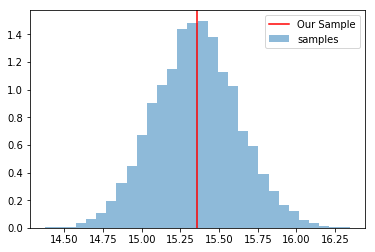

In [4]:
M_samples=10000
N_points = n_events.shape[0]
bs_np = np.ones(shape=(M_samples, N_points))
for i in range(M_samples):    
    bs_np[i,:] = np.random.choice(n_events, size=N_points, replace=True)
sd_mean=np.mean(bs_np, axis=1)
sd_std=np.std(bs_np, axis=1)
plt.hist(sd_mean, bins=30, normed=True, alpha=0.5,label="samples");
plt.axvline(n_events.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

Now we do it with a parametric Poisson distribution.

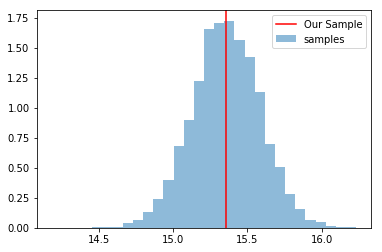

In [5]:
#Now parametric

from scipy.stats import poisson
M_samples=10000
N_points = n_events.shape[0]
bs_p = poisson.rvs(n_events.mean(),size=(M_samples, N_points))
sd_mean_p=np.mean(bs_p, axis=1)
sd_std_p=np.std(bs_p, axis=1)
plt.hist(sd_mean_p, bins=30, normed=True, alpha=0.5, label="samples");
plt.axvline(n_events.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

## Lomb-Scargle Periodogram
We have seen that we can find the period of a variable light curve by constructing the Lomb-Scargle periodogram and looking for the highest peak. The periodogram is a representation of the power of the different frequencies that compose the signal. Below we create 30 noisy measurements taken at irregular times, with a period of 0.3 days, and compute the Lomb-Scargle periodogram using the python package astroML. We also compute the significance by using bootstrap. It is pretty straightforward with astroML.

/Users/jmartine/anaconda/lib/python3.6/site-packages/astroML/time_series/periodogram.py:8: UserWarning: Using slow version of lomb_scargle. Install astroML_addons to use an optimized version
  warnings.warn("Using slow version of lomb_scargle. Install astroML_addons "


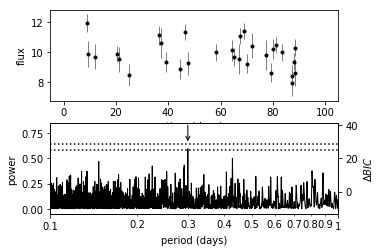

In [6]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 30
P = 0.3

t = np.random.randint(100, size=N) + 0.4 * np.random.random(N) # Times
y = 10 + np.sin(2 * np.pi * t / P)  # True magnitudes
dy = 0.5 + 0.5 * np.random.random(N)  # Magnitude errors
y_obs = np.random.normal(y, dy)       # Observed magnitudes

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000) # Periods where periodogram is evaluated
omega = 2 * np.pi / period  # Angular frequency
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True) # Periodogram

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=1000, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

#plt.show()

## SDSS Stripe 82 Light Curves
We will now look at some SDSS Stripe 82 light curves. We will find their periods, fold them, and see what they have to tell us about the variable source they represent.

In [7]:
# Load the data
import pandas as pd
df = pd.read_csv('Data_Lecture4/LC_1301781.dat', comment='#', delimiter=" ",names=["time","filter","mag","mag_err"])
df = df[df['mag'] >= 0] #Cleaning the data
df

,time,filter,mag,mag_err
0,51081.358382,r,17.969,0.007
1,51081.359215,i,17.845,0.007
2,51081.360049,u,19.406,0.030
3,51081.360882,z,17.809,0.022
4,51081.361715,g,18.251,0.007
5,51819.429492,r,17.927,0.007
6,51819.430325,i,17.860,0.008
7,51819.431159,u,19.439,0.037
8,51819.431992,z,17.835,0.026
9,51819.432825,g,18.209,0.007


In [8]:
# Here we just create arrays representing the different columns of the table.
#times = np.array(map(float,df.iloc[:,0].values))
times = df.iloc[:,0].values
#mags = np.array(map(float,df.iloc[:,2].values))
mags = df.iloc[:,2].values
#dmags = np.array(map(float,df.iloc[:,3].values))
dmags = df.iloc[:,3].values
filters = df.iloc[:,1].values

We can plot the unfolded light curve

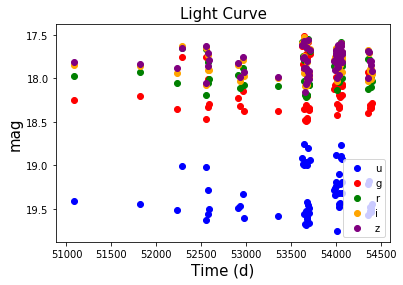

In [9]:
plt.scatter(times[filters == 'u'],mags[filters == 'u'],marker='o',color='b',label='u')
plt.scatter(times[filters == 'g'],mags[filters == 'g'],marker='o',color='r',label='g')
plt.scatter(times[filters == 'r'],mags[filters == 'r'],marker='o',color='g',label='r')
plt.scatter(times[filters == 'i'],mags[filters == 'i'],marker='o',color='orange',label='i')
plt.scatter(times[filters == 'z'],mags[filters == 'z'],marker='o',color='purple',label='z')
#plt.ylim(18,20.5)
#plt.xlim(0.,1.)
plt.title('Light Curve',size=15)
plt.xlabel('Time (d)',size=15)
plt.ylabel('mag',size=15)
plt.legend(loc=4)
plt.gca().invert_yaxis()

In [10]:
# Let's look at the r filter data only
mags_r = mags[filters == 'r']
times_r = times[filters == 'r']
dmags_r = dmags[filters == 'r']

mags_u = mags[filters == 'u']
times_u = times[filters == 'u']
dmags_u = dmags[filters == 'u']

mags_z = mags[filters == 'z']
times_z = times[filters == 'z']
dmags_z = dmags[filters == 'z']

Let's first use the single band periodogram to find the periods in the different bands.

Text(0.5,0,'Period (days)')

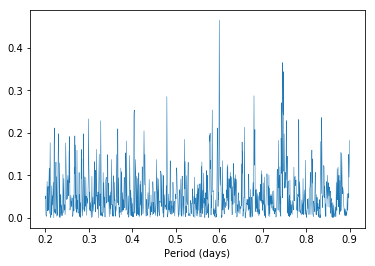

In [11]:
# Single band Lomb-Scargle for band r
from gatspy import periodic
periods = np.linspace(0.2, 0.9, 1000)
P = periodic.LombScargleAstroML().fit(times_r,mags_r,dmags_r).periodogram(periods)
plt.plot(periods, P, lw=0.5)
plt.xlabel('Period (days)')

Text(0.5,0,'Period (days)')

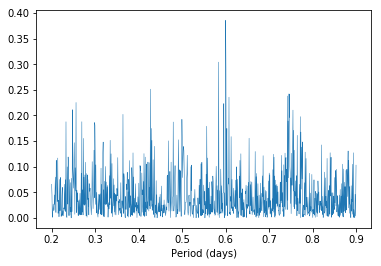

In [12]:
# Single band Lomb-Scargle for band u
from gatspy import periodic
periods = np.linspace(0.2, 0.9, 1000)
P = periodic.LombScargleAstroML().fit(times_u,mags_u,dmags_u).periodogram(periods)
plt.plot(periods, P, lw=0.5)
plt.xlabel('Period (days)')

Text(0.5,0,'Period (days)')

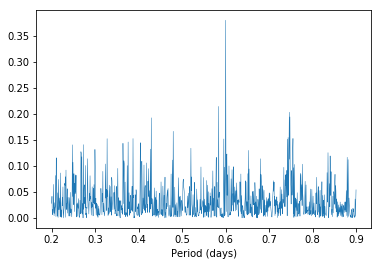

In [13]:
# Single band Lomb-Scargle for band z
from gatspy import periodic
periods = np.linspace(0.2, 0.9, 1000)
P = periodic.LombScargleAstroML().fit(times_z,mags_z,dmags_z).periodogram(periods)
plt.plot(periods, P, lw=0.5)
plt.xlabel('Period (days)')

Let's now do it using the Multi Band periodogram, which takes advantage of the information in all filters, by calculating an overall variability, and then deviations from that overall variability in each filter.

Text(0.5,0,'Period (days)')

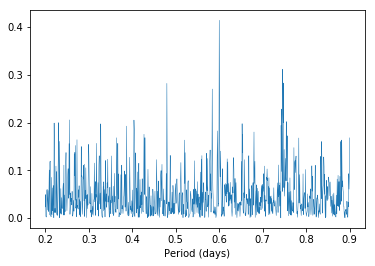

In [14]:
P_multi = periodic.LombScargleMultiband(Nterms_base=1, Nterms_band=0).fit(times,mags,dmags,filters).periodogram(periods)
plt.plot(periods, P_multi, lw=0.5)
plt.xlabel('Period (days)')

And now let's fit to find the best period:

In [15]:
ls = periodic.LombScargleMultiband(fit_period=True,Nterms_base=1, Nterms_band=0)
ls.optimizer.period_range = (0.2, 0.9)
ls.fit(times,mags,dmags,filters)
period = ls.best_period
print ('Best period: ', period)

Finding optimal frequency:
 - Estimated peak width = 0.00189
 - Using 5 steps per peak; omega_step = 0.000378
 - User-specified period range:  0.2 to 0.9
 - Computing periods at 64577 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Best period:  0.6010505641943096


In [16]:
foldTimes =  times / period  # divide by period to convert to phase
foldTimes = foldTimes % 1   # take fractional part of phase only (i.e. discard whole number part)

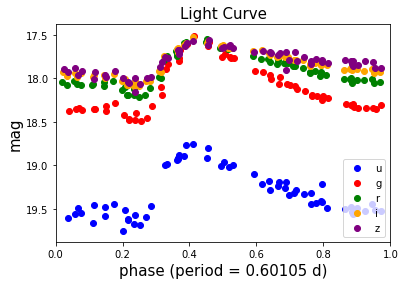

In [17]:
# Now we plot the light curve
# plot folded lightcurve
plt.scatter(foldTimes[filters == 'u'],mags[filters == 'u'],marker='o',color='b',label='u')
plt.scatter(foldTimes[filters == 'g'],mags[filters == 'g'],marker='o',color='r',label='g')
plt.scatter(foldTimes[filters == 'r'],mags[filters == 'r'],marker='o',color='g',label='r')
plt.scatter(foldTimes[filters == 'i'],mags[filters == 'i'],marker='o',color='orange',label='i')
plt.scatter(foldTimes[filters == 'z'],mags[filters == 'z'],marker='o',color='purple',label='z')
#plt.ylim(18,20.5)
plt.xlim(0.,1.)
plt.title('Light Curve',size=15)
plt.xlabel('phase (period = 0.60105 d)',size=15)
plt.ylabel('mag',size=15)
plt.legend(loc=4)
plt.gca().invert_yaxis()

### Exercise
1. Find the periods for the remianing light curves of the dataset, using both single-band periodogram and the multi-band periodogram. What is the range of periods you find? Are all light curves similar?

2. Plot the periodograms. So you see any other significant period peaks? Try to fold the light curves with the highest and second and third hightst peaks. 

3. Using bootstrapping, find the significance of the main peak in each case. How likely is it to find the periodicity if the null hypothesis is assumed?

4. Suppose that you have the following magnitude limits in the different bands:

* $r$, $i$, $z$ bands: 18 mag
* $g$ band: 18.5 mag
* $u$ babd: 19 mag.

Repeat the period finding analysos under these conditions. What do you find?
